# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** EfficientNet-B0

In [21]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Note: you may need to restart the kernel to use updated packages.
Device: cpu


In [ ]:
# Paths (change these to your dataset locations)
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [23]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129])


In [ ]:
# EfficientNet-B0 (torchvision if available)
try:
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # If torchvision doesn't have efficientnet in your environment, use timm (uncomment install if needed)
    # !pip install timm -q
    import timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


In [25]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 10  # change as needed


In [26]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [27]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="EfficientNet-B0")


Epoch 1/10


100%|██████████| 333/333 [09:51<00:00,  1.78s/it]


train Loss: 1.3077 Acc: 0.5137 F1: 0.4927


100%|██████████| 42/42 [00:24<00:00,  1.74it/s]


val Loss: 0.7913 Acc: 0.7016 F1: 0.7120
------------------------------
Epoch 2/10


100%|██████████| 333/333 [09:36<00:00,  1.73s/it]


train Loss: 0.7266 Acc: 0.6874 F1: 0.6809


100%|██████████| 42/42 [00:22<00:00,  1.89it/s]


val Loss: 0.5355 Acc: 0.7965 F1: 0.7911
------------------------------
Epoch 3/10


100%|██████████| 333/333 [09:42<00:00,  1.75s/it]


train Loss: 0.5960 Acc: 0.7493 F1: 0.7369


100%|██████████| 42/42 [00:21<00:00,  1.91it/s]


val Loss: 0.3919 Acc: 0.8598 F1: 0.8439
------------------------------
Epoch 4/10


100%|██████████| 333/333 [09:31<00:00,  1.71s/it]


train Loss: 0.4935 Acc: 0.7878 F1: 0.7752


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


val Loss: 0.3220 Acc: 0.8847 F1: 0.8586
------------------------------
Epoch 5/10


100%|██████████| 333/333 [09:41<00:00,  1.75s/it]


train Loss: 0.4305 Acc: 0.8213 F1: 0.8070


100%|██████████| 42/42 [00:22<00:00,  1.85it/s]


val Loss: 0.2576 Acc: 0.9050 F1: 0.8861
------------------------------
Epoch 6/10


100%|██████████| 333/333 [09:44<00:00,  1.76s/it]


train Loss: 0.3736 Acc: 0.8403 F1: 0.8328


100%|██████████| 42/42 [00:23<00:00,  1.81it/s]


val Loss: 0.2068 Acc: 0.9246 F1: 0.9119
------------------------------
Epoch 7/10


100%|██████████| 333/333 [09:38<00:00,  1.74s/it]


train Loss: 0.3640 Acc: 0.8522 F1: 0.8349


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]


val Loss: 0.2099 Acc: 0.9209 F1: 0.8922
------------------------------
Epoch 8/10


100%|██████████| 333/333 [09:32<00:00,  1.72s/it]


train Loss: 0.3360 Acc: 0.8650 F1: 0.8551


100%|██████████| 42/42 [00:22<00:00,  1.83it/s]


val Loss: 0.1783 Acc: 0.9314 F1: 0.9097
------------------------------
Epoch 9/10


100%|██████████| 333/333 [09:20<00:00,  1.68s/it]


train Loss: 0.3113 Acc: 0.8733 F1: 0.8635


100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


val Loss: 0.1529 Acc: 0.9465 F1: 0.9260
------------------------------
Epoch 10/10


100%|██████████| 333/333 [09:33<00:00,  1.72s/it]


train Loss: 0.2943 Acc: 0.8766 F1: 0.8657


100%|██████████| 42/42 [00:23<00:00,  1.80it/s]

val Loss: 0.1552 Acc: 0.9457 F1: 0.9244
------------------------------
Training complete in 100m 2s
Best val F1: 0.9260


In [28]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


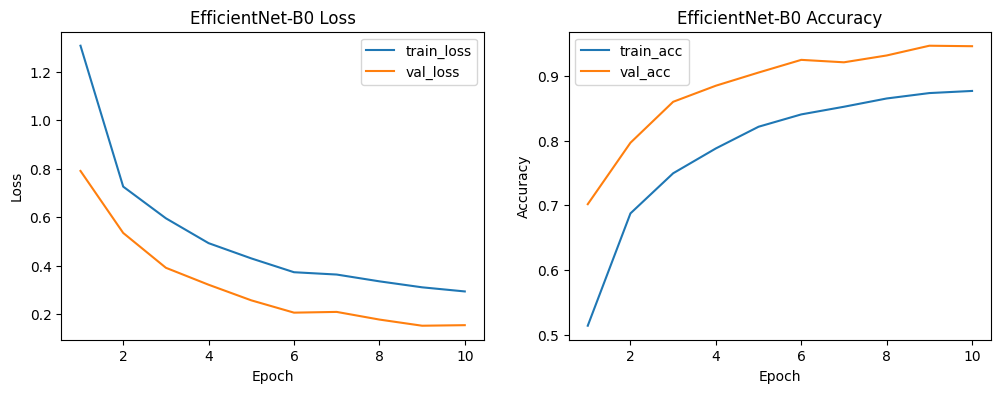

In [29]:
plot_history(history, model_name="EfficientNet-B0")


In [32]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


In [33]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.85      0.86      0.86        86
             Chickenpox       0.91      0.96      0.93       112
                 Cowpox       0.98      0.99      0.98        99
         Dermatofibroma       0.79      0.96      0.86        23
                   HFMD       0.95      0.99      0.97       241
                Healthy       0.97      0.98      0.97       171
                Measles       0.93      0.99      0.96        82
              Monkeypox       0.99      0.93      0.96       426
Squamous cell carcinoma       0.80      0.73      0.76        62
       Vascular lesions       1.00      1.00      1.00        25

               accuracy                           0.95      1327
              macro avg       0.92      0.94      0.93      1327
           weighted avg       0.95      0.95      0.95      1327

Confusion matrix:
 [[ 74   0   0   1   0   0   0   0  11   0]
 [  0 107   0   0   1   0